In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d asifhasan24/raw-dataset
!unzip /content/raw-dataset.zip
!pip install gradio
!pip install shap
!pip install -U tensorflow-addons

/content
raw-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/raw-dataset.zip
replace Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: gradio in /usr/local/lib/python3.10/dist-packages (4.16.0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import os
from glob import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import gc
from skimage import exposure
from scipy.ndimage import gaussian_filter

# Explicitly call the garbage collector if needed
gc.collect()

# Set data directory
train_data_directory = "/content/Raw Dataset"

# Define classes
classes = ["Cescospora Leaf Spot", "Golden Mosaic", "Healthy Leaf"]
num_classes = 3
img_size = 224
def enhance_image(image):
    # Apply Unsharp Masking
    gaussian_blur = cv2.GaussianBlur(image, (0, 0), 3)
    unsharp_image = cv2.addWeighted(image, 1.5, gaussian_blur, -0.5, 0)

    return unsharp_image

# Load training data with unsharp masking
def load_images_from_directory(directory, random_state=None):
    images = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for image_file in image_files:
            image = cv2.imread(image_file)

            image = cv2.resize(image, (img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply unsharp masking
            # image = enhance_image(image)

            images.append(image)
            labels.append(class_index)

    images = np.array(images)
    labels = np.array(labels)

    # Use train_test_split to shuffle and split the data
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=random_state, stratify=labels)

    return x_train, y_train, x_test, y_test  # Return both training and test sets



# Load training data
x_train, y_train, x_test, y_test = load_images_from_directory(train_data_directory, random_state=42)



# Print shapes
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



x_train shape: (736, 224, 224, 3) - y_train shape: (736,)
x_test shape: (184, 224, 224, 3) - y_test shape: (184,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data with augmentation
def load_augmented_images_from_directory(directory, datagen):
    images = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for image_file in image_files:
            image = cv2.imread(image_file)

            image = cv2.resize(image, (img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Expand the dimensions of the image to (1, img_size, img_size, 3)
            image = np.expand_dims(image, axis=0)

            # Apply data augmentation
            augmented_images = datagen.flow(image, batch_size=1)

            # Append augmented images and labels
            for i in range(5):  # You can adjust the number of augmented images per original image
                augmented_image = augmented_images.next()[0]
                images.append(augmented_image)
                labels.append(class_index)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load augmented training data
x_train, y_train = load_augmented_images_from_directory(train_data_directory, datagen)

# Print shapes
print(f"x_train_augmented shape: {x_train.shape} - y_train_augmented shape: {y_train.shape}")


x_train_augmented shape: (4600, 224, 224, 3) - y_train_augmented shape: (4600,)


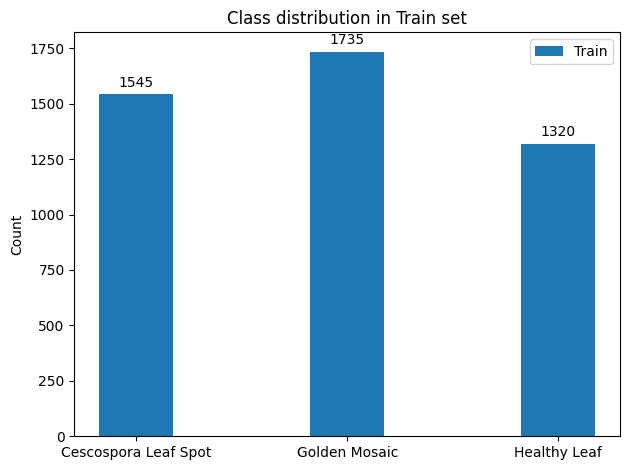

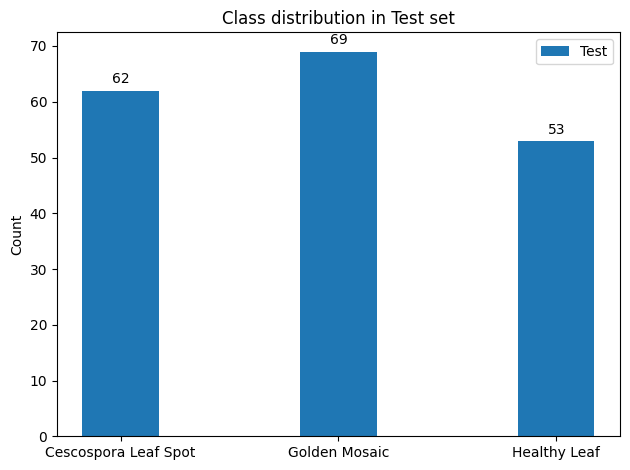

In [ ]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(y_data, title, classes):
    class_counts = [np.sum(y_data == i) for i in range(len(classes))]

    width = 0.35  # the width of the bars
    ind = np.arange(len(classes))  # the label locations

    fig, ax = plt.subplots()
    rects = ax.bar(ind, class_counts, width, label=title)

    ax.set_ylabel('Count')
    ax.set_title(f'Class distribution in {title} set')
    ax.set_xticks(ind)
    ax.set_xticklabels(classes)
    ax.legend()

    def autolabel(rects):
        """Attach a label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects)

    fig.tight_layout()

# Plot class distribution for the training set
plot_class_distribution(y_train, 'Train', classes)
plt.show()

# Plot class distribution for the testing set
plot_class_distribution(y_test, 'Test', classes)
plt.show()


In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

from keras.applications.densenet import DenseNet201
# Define the input image size
image_size = [224, 224]

# Load the DenseNet201 model
densenet = DenseNet201(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Freeze the layers in the DenseNet model
for layer in densenet.layers:
    layer.trainable = False

# Replace Flatten layer with GlobalAveragePooling2D for better performance
x = GlobalAveragePooling2D()(densenet.output)

# Additional Dense layers for classification
prediction = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=densenet.input, outputs=prediction)
model.summary()

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss_function = SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Assuming x_train, y_train, x_test, y_test are defined and preprocessed
# Train the model
batch_size = 64
epochs = 10
shuffle = True

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=shuffle, validation_data=(x_test, y_test))

# Evaluate and save the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

model.save("trained_model_densenet201.h5")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 4s 147ms/step


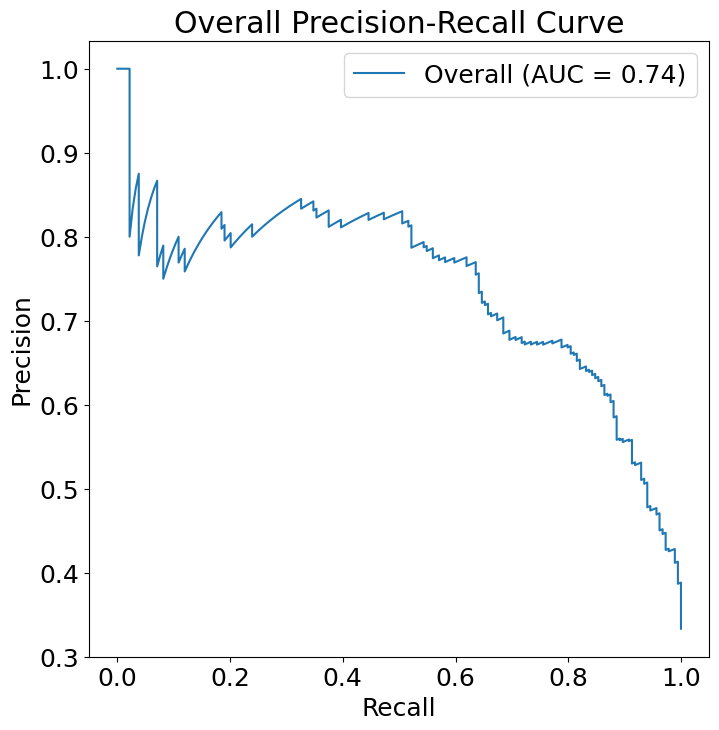

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Get predicted probabilities for each class
y_pred_prob = model.predict(x_test)

# Flatten the arrays
y_test_flat = y_test_one_hot.ravel()
y_pred_prob_flat = y_pred_prob.ravel()

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_flat, y_pred_prob_flat)
pr_auc = auc(recall, precision)

# Plot the overall precision-recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label=f'Overall (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve')
plt.legend()
plt.show()


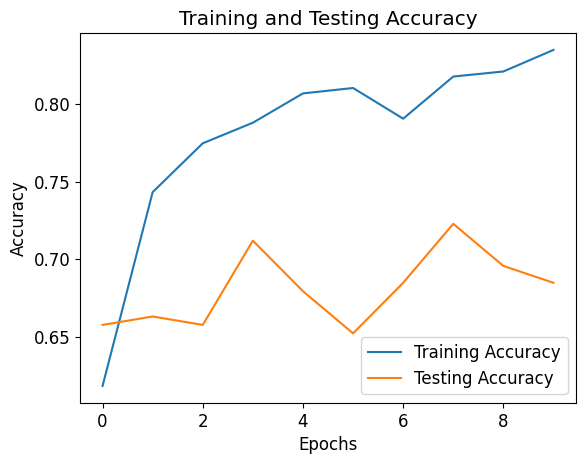

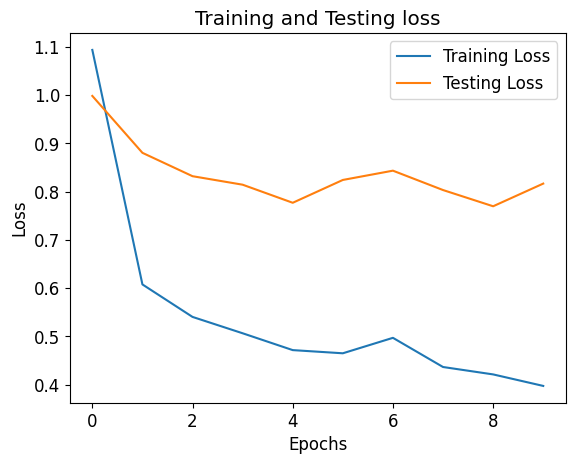

In [ ]:
# Plot the accuracy curves
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# Plot training accuracy and validation/test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot the accuracy curves
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# Plot training accuracy and validation/test accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 5s 151ms/step


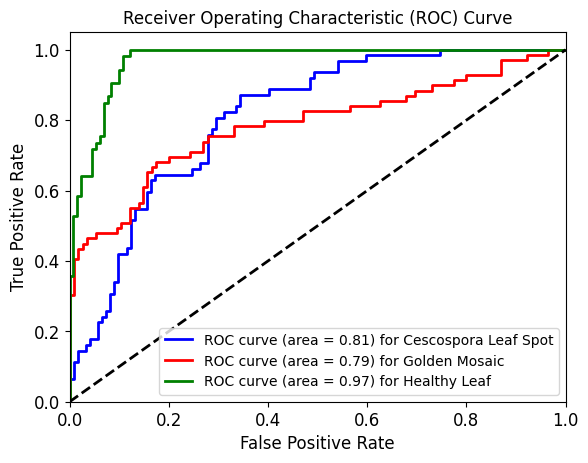

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Get the predicted probabilities for each class
y_pred_proba = model.predict([x_test])

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(num_classes):
    y_true_binary = y_test == class_index
    fpr[class_index], tpr[class_index], _ = roc_curve(y_true_binary, y_pred_proba[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Plot the ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust the colors as needed
for class_index in range(num_classes):
    plt.plot(fpr[class_index], tpr[class_index], color=colors[class_index], lw=2,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[class_index], classes[class_index]))
plt.rcParams.update({'font.size': 10})
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


6/6 [==============================] - 1s 135ms/step


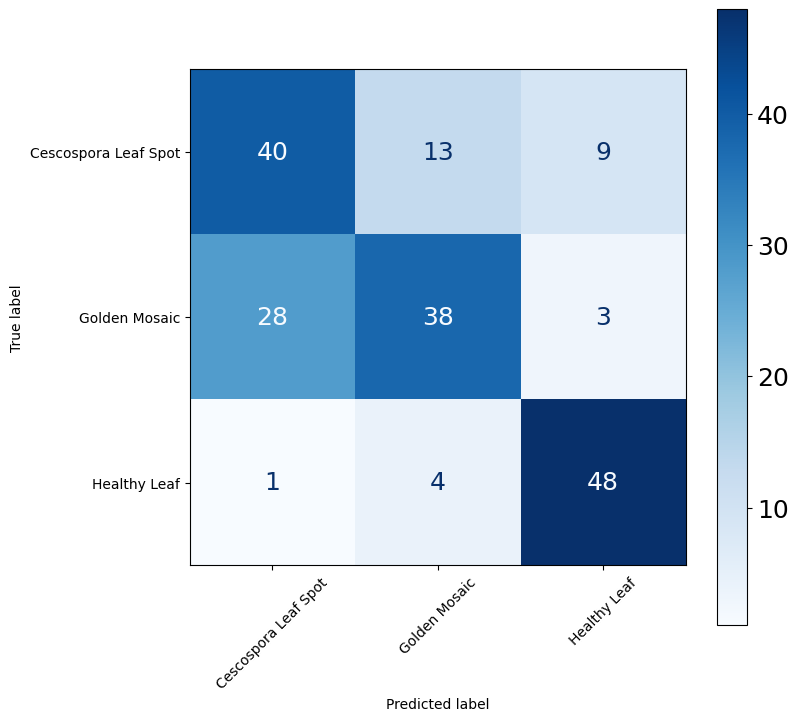

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
# model = load_model("/content/trained_model.h5")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
predictions = np.argmax(model.predict([x_test]), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
#"Col_Ade", "Col_Ben","lun_Ben","lun_Ade","lun_Squ"
# Plot the confusion matrix
# labels =["Field Cricket", "Jute Stem Weevil", "Spilosoma Obliqua", "Yellow Mite"]
labels = ["Cescospora Leaf Spot", "Golden Mosaic", "Healthy Leaf"] # The class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})  # Adjust the figure size if needed
disp.plot(cmap=plt.cm.Blues, ax=ax)
# plt.title("Confusion Matrix")
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.savefig('confusion_matrix6.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get the predicted class labels for the test set
predictions = model.predict([x_test])
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy, precision, recall, and F1-score for each class
class_accuracies = []
class_precisions = []
class_recalls = []
class_f1_scores = []
for class_index in range(num_classes):
    y_true_binary = y_test == class_index
    predictions_binary = predicted_labels == class_index
    class_accuracy = accuracy_score(y_true_binary, predictions_binary)
    class_precision = precision_score(y_true_binary, predictions_binary)
    class_recall = recall_score(y_true_binary, predictions_binary)
    class_f1_score = f1_score(y_true_binary, predictions_binary)
    class_accuracies.append(class_accuracy)
    class_precisions.append(class_precision)
    class_recalls.append(class_recall)
    class_f1_scores.append(class_f1_score)

# Print the accuracy, precision, recall, and F1-score for each class
for class_index in range(num_classes):
    print(f"Class {class_index} Accuracy: {class_accuracies[class_index]:.4f}")
    print(f"Class {class_index} Precision: {class_precisions[class_index]:.4f}")
    print(f"Class {class_index} Recall: {class_recalls[class_index]:.4f}")
    print(f"Class {class_index} F1-score: {class_f1_scores[class_index]:.4f}")


6/6 [==============================] - 1s 137ms/step
Class 0 Accuracy: 0.7228
Class 0 Precision: 0.5797
Class 0 Recall: 0.6452
Class 0 F1-score: 0.6107
Class 1 Accuracy: 0.7391
Class 1 Precision: 0.6909
Class 1 Recall: 0.5507
Class 1 F1-score: 0.6129
Class 2 Accuracy: 0.9076
Class 2 Precision: 0.8000
Class 2 Recall: 0.9057
Class 2 F1-score: 0.8496
